In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 465 kB 67.8 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

df = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/ai/식품/dataset.xlsx")
X= pd.DataFrame({ 'Name' : df.iloc[:,0] })
y= pd.DataFrame({ 'S' : df.iloc[0:,2] })

In [ ]:
import re
from konlpy.tag import Okt  
okt=Okt()  
sub_dic = [] ; dic = {} ; lst = []
for i, item in enumerate(list(X.iloc[:,0])):
    sub_str = re.sub('[a-zA-Z0-9]', "", item)
    X.iloc[i,0] = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", sub_str)
    X.iloc[i,0] = okt.morphs(X.iloc[i,0])
    Max = max(len(X.iloc[i,0]), len(X.iloc[i-1,0]))
    sub_dic.extend(X.iloc[i,0])

sub_dic = list(set(sub_dic))
print(X)
for i, item in enumerate(sub_dic):
  dic[item] = i

for i, item in enumerate(list(X.iloc[:,0])):
  for j in item:
    lst.append(dic[j])
  X.iloc[i,0] = lst
  lst = []
print(X)

                                                 Name
0                   [꿀, 당, 도, 프리미엄, 정품, 사과, 당, 도선, 별]
1     [프레, 샤인, 충주, 인증, 당, 도선, 별, 작아도, 맛있는, 꼬마, 사과, 봉]
2                  [곰곰, 의성, 껍질, 째, 먹는, 세척, 사과, 박스, 입]
3             [하이, 프루츠, 저, 탄소, 인증, 의성, 사과, 과, 내외, 대과]
4                        [곰곰, 당, 도선, 별, 사과, 햇, 봉, 대과]
..                                                ...
75               [참다, 올, 남양주, 먹골, 배, 프리미엄, 선물, 세트, 과]
76  [품평, 회, 대상, 명품, 햇, 나주, 배, 선물, 세트, 나주, 배, 선물, 세...
77      [아산, 배, 농협, 배, 산지, 직송, 서양배, 스, 위트, 센세이션, 유렵배]
78        [소담, 촌, 수확, 햇배, 가정, 용, 첫, 수확, 박스, 과, 중소, 과]
79  [품평, 회, 대상, 명품, 햇, 나주, 배, 선물, 세트, 나주, 배, 선물, 세...

[80 rows x 1 columns]
                                                 Name
0             [183, 82, 146, 14, 19, 11, 82, 136, 58]
1   [121, 138, 174, 4, 82, 136, 58, 129, 70, 61, 1...
2            [147, 150, 1, 86, 107, 43, 11, 151, 155]
3      [184, 133, 199, 141, 4, 150, 11, 52, 186, 207]
4                [147, 82, 136, 58, 11, 196, 28, 207]
..   

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Model
from tensorflow.keras.preprocessing import sequence

label = y.iloc[:,0].unique()
for i,item in enumerate(label):
  y = y.replace(item,i)
y = tf.keras.utils.to_categorical(y,2)

X = sequence.pad_sequences(X.iloc[:,0], maxlen = 14)

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

def jpg_image_to_array(image_path,size):
  image = Image.open(image_path)
  image = image.resize((size,size))
  im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
  im_arr = im_arr.reshape((image.size[1], image.size[0], 3))
  return im_arr

dir = '/content/gdrive/MyDrive/Colab Notebooks/ai/식품/사과,배'

subdir_names = os.listdir(dir)
X_img = [] ; y_img = []
for subdir_name in subdir_names:
  subdir = dir + "/" + subdir_name
  file_names = os.listdir(subdir)
  for file_name in file_names:
    path = subdir + "/" + file_name
    arr = jpg_image_to_array(path, 224)
    if len(X_img)==0:
      X_img = [arr]
      y_img.append(str(subdir_name))

    else:
      X_img = np.concatenate((X_img, [arr]))
      y_img.append(str(subdir_name))


print(X_img.shape)
print(len(y_img))


<ipython-input-6-2d6ff8c53164>:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)


(80, 224, 224, 3)
80


In [ ]:
X_img = X_img/255

In [ ]:
y_img = pd.DataFrame(y_img, dtype='str')
label = y_img.iloc[:,0].unique()
for i,item in enumerate(label):
  y_img = y_img.replace(item,i)
y_img = tf.keras.utils.to_categorical(y_img,2)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=77)
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(X_img, y_img, stratify=y, test_size=0.25, random_state=77)

In [ ]:
for i, j in zip(y_test, y_test_img):
  if i[0] == j[0]:
    continue
  else:
    print(i, j)
    print('타겟 데이터가 다른 record끼리 연결되었습니다.')
    break

In [ ]:
model_CS_input = layers.Input((14,1))
model_CS = layers.Conv1D(filters=16, kernel_size=2, strides=1, padding='same', 
                        activation='relu')(model_CS_input)
model_CS = layers.LSTM(64)(model_CS)
model_CS = layers.Dense(2, activation='sigmoid')(model_CS)

import tensorflow_hub as hub

url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'
model_CNN_input = layers.Input((224, 224, 3))
model_CNN = hub.KerasLayer(handle = url, trainable = False)(model_CNN_input)
model_CNN = layers.Flatten()(model_CNN)
model_CNN = layers.Dense(2, activation='sigmoid')(model_CNN)



In [ ]:
merged = tf.keras.layers.Concatenate()([model_CNN, model_CS])
merged = layers.Dense(8, activation='relu')(merged)
output = layers.Dense(2, activation='sigmoid')(merged)
model_final = Model(inputs=[model_CS_input, model_CNN_input], outputs=[output])

In [ ]:
model_final.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
hist_Merge = model_final.fit([X_train,X_train_img],y_train,
          batch_size=3,
          epochs=100,
          validation_split=0.1,
          callbacks = early_stop,
          shuffle=True,
          verbose=1)

Epoch 1/100
18/18 [==============================] - 15s 231ms/step - loss: 0.6812 - accuracy: 0.7037 - val_loss: 0.6464 - val_accuracy: 1.0000
Epoch 2/100
18/18 [==============================] - 2s 123ms/step - loss: 0.6376 - accuracy: 0.9259 - val_loss: 0.6180 - val_accuracy: 1.0000
Epoch 3/100
18/18 [==============================] - 2s 126ms/step - loss: 0.6039 - accuracy: 0.9630 - val_loss: 0.6096 - val_accuracy: 1.0000
Epoch 4/100
18/18 [==============================] - 2s 122ms/step - loss: 0.5767 - accuracy: 0.9815 - val_loss: 0.5824 - val_accuracy: 1.0000
Epoch 5/100
18/18 [==============================] - 2s 125ms/step - loss: 0.5540 - accuracy: 1.0000 - val_loss: 0.5647 - val_accuracy: 1.0000
Epoch 6/100
18/18 [==============================] - 2s 123ms/step - loss: 0.5323 - accuracy: 1.0000 - val_loss: 0.5554 - val_accuracy: 1.0000
Epoch 7/100
18/18 [==============================] - 2s 121ms/step - loss: 0.5105 - accuracy: 1.0000 - val_loss: 0.5336 - val_accuracy: 1.000

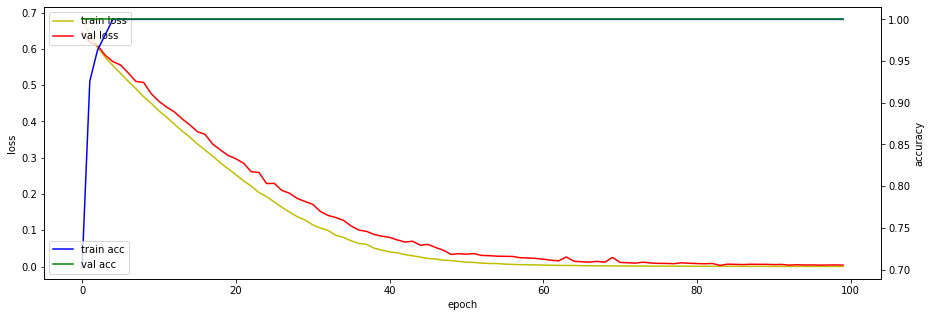

In [ ]:
fig, loss_ax = plt.subplots(figsize=(15,5))
acc_ax = loss_ax.twinx()

loss_ax.plot(hist_Merge.history['loss'],'y', label = 'train loss')
loss_ax.plot(hist_Merge.history['val_loss'],'r', label = 'val loss')
acc_ax.plot(hist_Merge.history['accuracy'],'b', label = 'train acc')
acc_ax.plot(hist_Merge.history['val_accuracy'],'g', label = 'val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
score_Merge = model_final.evaluate([X_test, X_test_img], y_test)
print('test_loss : ' , score_Merge[0], 'test_acc :' , score_Merge[1])

1/1 [==============================] - 2s 2s/step - loss: 0.0019 - accuracy: 1.0000
test_loss :  0.0019188951700925827 test_acc : 1.0
